# Module: Dust attenuation

> Adding dust attenuation based on DustE modelling

In [ ]:
#| default_exp dust_attenuation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import matplotlib.pylab as plt
import astropy.units as u
from astropy.cosmology import Planck13, z_at_value

In [ ]:
#| export
import numpy as np
from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.calculate_csp import calc_fluxes_for_galaxy
from watercolor.load_sim_stellar_catalog import GALS_FILE
from watercolor.load_sps_library import LIBRARY_FLUX_FILE, LIBRARY_WAVE_FILE, LIBRARY_AGE_FILE, LIBRARY_METAL_FILE

In [ ]:
#| export

import sys
import os
from duste.DustAttnCalc import DustAttnCalc # https://github.com/Astropianist/DustE
from io import StringIO
from contextlib import contextmanager

In [ ]:
#| hide 
fof_halo_tag, if_satellite, galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, _, _, _, _, _, _ = load_hacc_galaxy_data(GALS_FILE)

In [ ]:
#| hide 

galaxy_number = 4
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(GALS_FILE,
                                                                                              unique_galaxy_tag,
                                                                                              LIBRARY_FLUX_FILE,
                                                                                              LIBRARY_WAVE_FILE,
                                                                                              LIBRARY_AGE_FILE,
                                                                                              LIBRARY_METAL_FILE)

In [ ]:
#| hide
# z_at_value(Planck13.age, 2 * u.Gyr) 

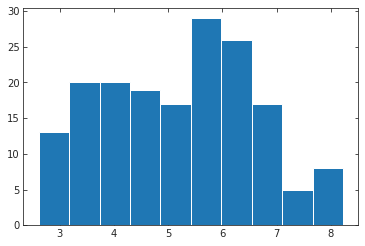

In [ ]:
#| hide

plt.hist(age_hydro[galaxy_tags == unique_galaxy_tag], bins=10);

In [ ]:
#| export

# # Disable
# def blockPrint():
#     sys._jupyter_stdout = sys.stdout
#     sys.stdout = open(os.devnull, 'w')

# # Restore
# def enablePrint():
#     sys._jupyter_stdout = sys.stdout
#     sys.stdout = sys.__stdout__


@contextmanager
def hidden_prints(
                ): #Utility function to hide the print statements from duste
    original_stdout = sys.stdout
    sys.stdout = StringIO()
    yield
    sys.stdout = original_stdout
    

def spectrum_dusted(pcolor:np.array=None, # SED without dust attenuation
                  wave:np.array=None, # Wavelength in Angstorms
                  logmstar:np.float32=None, # Log(stellar mass) of the galaxy
                  metal:np.float32=None, # log(metallicity) of the galaxy
                  galaxy_redshift:np.float32=None # Redshift of the galaxy
                  )-> np.array: # Dust attenuated SED
     
    # blockPrint()
    
    with hidden_prints():
    
        dust_attn = DustAttnCalc(logM=logmstar, 
                                 # sfr=SFRz, 
                                 logZ=metal, 
                                 z = galaxy_redshift, 
                                 bv=1, 
                                 eff=0, 
                                 wv_arr=wave); # Two-component bivariate dust model (fitting both optical depth and slope) 

        dac, dac1, n, tau, tau1, n_err, tau_err, tau1_err = dust_attn.calcDust(plot_tau=False, max_num_plot=2);
    
    dac_avg, dac1_avg = np.average(dac, axis=0), np.average(dac1, axis=0)
    dust_ext_fac0 = np.exp(-1*dac_avg)*np.exp(-1*dac1_avg) #correct
    pcolor_attn = pcolor*dust_ext_fac0[0, :];
    
    # enablePrint()
    
    return pcolor_attn



def log_total_stellar_metal(stellar_metal_i:np.array=None, # Array with individual stellar metallicities of the star particles
                       stellar_mass_i:np.array=None, # Array with individual stellar masses of the star particles
                      )-> np.float32: # Total stellar metallicity of the galaxy
    
    total_stellar_mass = np.sum(stellar_mass_i)
    weighted_metal = np.sum(stellar_mass_i*stellar_metal_i)
    weighted_sum_metal = weighted_metal/total_stellar_mass
    return np.array([np.log10(weighted_sum_metal)])

def log_total_stellar_mass(stellar_mass_i:np.array=None, # Array with individual stellar masses of the star particles
                      )-> np.float32: # Total stellar mass of the galaxy
    total_stellar_mass = np.sum(stellar_mass_i)
    return np.array([np.log10(total_stellar_mass)])

In [ ]:
#| hide



# logmstar = np.array([np.log10( np.sum(mass[galaxy_tags == unique_galaxy_tag]))])
# logZ = np.array([np.mean(metal_hydro[galaxy_tags == unique_galaxy_tag])])


mstar_i = mass[galaxy_tags == unique_galaxy_tag]
metal_i = metal_hydro[galaxy_tags == unique_galaxy_tag]

logZ = log_total_stellar_metal(metal_i, mstar_i)
logmstar = log_total_stellar_mass(mstar_i)


spec_wave_csp_dusted = spectrum_dusted(spec_csp, spec_wave_ssp, logmstar, logZ, 0.001)

<matplotlib.legend.Legend>

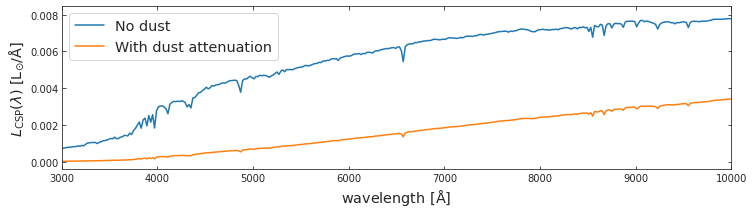

In [ ]:
#| hide 

f, a = plt.subplots(1, 1, figsize=(12, 3))
a.plot(spec_wave_ssp, spec_csp, label='No dust')
a.plot(spec_wave_ssp, spec_wave_csp_dusted, label='With dust attenuation')



a.set_xlim(3e3, 1e4)

a.set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a.set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a.legend(fontsize='x-large')

In [ ]:
#| hide

# logM = np.random.uniform(8.74,11.30,ngal)
# sfr = np.random.uniform(-2.06,2.11,ngal)
# logZ = np.random.uniform(-1.70,0.18,ngal)


for galaxy_number in range(10):
    
    unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]
    mstar_i = mass[galaxy_tags == unique_galaxy_tag]
    metal_i = metal_hydro[galaxy_tags == unique_galaxy_tag]

    logZ = log_total_stellar_metal(metal_i, mstar_i)
    logmstar = log_total_stellar_mass(mstar_i)
    
    print(logmstar, logZ)

[9.45305866] [-1.61214235]
[9.48274661] [-1.56558937]
[9.28027298] [-1.49156686]
[10.81558224] [-0.96863435]
[10.51728804] [-1.08748047]
[9.57835839] [-1.61712595]
[9.55768592] [-1.66959933]
[10.19415785] [-1.43520877]
[10.75407759] [-0.96404706]
[10.13143665] [-1.27303116]


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()